# Traffic flow of Metropolis

## Goal

- Predict the next 12 hours of traffic flow in a U.S. metropolis.

## Metric
- Mean absolute error between predicted and actual congestion.

$$ MAE = \sum_{i=1}^{n} |y_{i}-x_{i}| \over n$$

## Data

- `row_id`: a unique identifier for this instance
- `time`: the 20-minute period in which each measurement was taken
- `x`: the east-west midpoint coordinate of the roadway
- `y`: the north-south midpoint coordinate of the roadway
- `direction`: the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
- `congestion` <font color="red"><b>(target)</b></font>: congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.

## Load packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import datetime as dt
import warnings
!pip install catch22
import catch22

warnings.filterwarnings("ignore")

train = pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv", index_col="row_id", parse_dates=['time'])
test = pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv", index_col="row_id", parse_dates=['time'])
sub = pd.read_csv("../input/tabular-playground-series-mar-2022/sample_submission.csv", index_col="row_id")

  Preparing metadata (setup.py) ... - \ done
  Created wheel for catch22: filename=catch22-0.2.0-cp37-cp37m-linux_x86_64.whl size=147098 sha256=ee4c35b3728cc37e0134dbb95ced9fb10c69aafe2306752d9f5aa1a8a4f967ad
  Stored in directory: /root/.cache/pip/wheels/df/0b/f1/d6442e61fab7d543943fc539691cfffcd020e9275b8814183f
Successfully built catch22


## Preprocessing

In [2]:
def add_vars(df):
    df["road"] = df['x'].astype(str) + df['y'].astype(str) + df['direction'].astype(str)
    df["month"]= df.time.dt.month
    df["week"]= df.time.dt.week
    df['weekend'] = (df.time.dt.weekday >= 5).astype("int8")
    df["day"]= df.time.dt.day
    df['hour'] = df.time.dt.hour
    df['afternoon'] = (df.hour >= 12).astype("int8")
    df['minute'] = df.time.dt.minute
    df['moment']  = df.time.dt.hour * 3 + df.time.dt.minute // 20
    df['dow'] = df.time.dt.dayofweek
    df['rolling_7_std'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: x.rolling(7).std())
    df['yesterday'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: x.shift(1))
    df['lastweek'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: x.shift(7))
    df['SB_BinaryStats_mean_longstretch1'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.SB_BinaryStats_mean_longstretch1(x.dropna().tolist()))
    df['DN_OutlierInclude_n_001_mdrmd'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.DN_OutlierInclude_n_001_mdrmd(x.dropna().tolist()))
    df['DN_OutlierInclude_p_001_mdrmd'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.DN_OutlierInclude_p_001_mdrmd(x.dropna().tolist()))
    df['CO_f1ecac'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.CO_f1ecac(x.dropna().tolist()))
    df['CO_FirstMin_ac'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.CO_FirstMin_ac(x.dropna().tolist()))
    df['CO_trev_1_num'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.CO_trev_1_num(x.dropna().tolist()))
    df['MD_hrv_classic_pnn40'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.MD_hrv_classic_pnn40(x.dropna().tolist()))
    df['PD_PeriodicityWang_th0_01'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.PD_PeriodicityWang_th0_01(x.dropna().tolist()))
    df['SB_BinaryStats_diff_longstretch0'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.SB_BinaryStats_diff_longstretch0(x.dropna().tolist()))    
    df['MD_hrv_classic_pnn40'] = train.groupby(['road', 'dow', 'hour', 'minute'])['congestion'].transform(lambda x: catch22.MD_hrv_classic_pnn40(x.dropna().tolist()))    
      
    # agg vars
    agg_df =  pd.DataFrame(train.groupby(['road', 'dow', 'hour', 'minute']).agg(
            cong_min = ('congestion', min),
            cong_max =('congestion', max),
            cong_mean =('congestion', np.mean),
            cong_median=("congestion", np.median)
        ).astype(int)).reset_index()
    df = df.merge(agg_df, on=['road', 'dow', 'hour', 'minute'], how='left')
    return df

train = add_vars(train)
test = add_vars(test)

train = pd.get_dummies(train, columns=["road", "direction"])
test = pd.get_dummies(test, columns=["road", "direction"])

## Creating the validation set

In [3]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = train[(train['time'] >= tst_start) & (train['time'] <= tst_finish)]
valid_target = valid_test.pop('congestion')

valid_sample_submission = valid_test.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

valid_train = train[train['time'] < tst_start]

X_train_v = valid_train.copy()

X_train_v = X_train_v.drop(["time"], axis=1)
y_train_v = X_train_v['congestion']
X_train_v = X_train_v.drop(['congestion'], axis=1)

X_test_v = valid_test.drop(["time"], axis=1)

## Train the XGboost algorithm

In [4]:
clf = xgb.XGBRegressor(
n_estimators = 500,
    learning_rate = 0.025,
    max_depth = 9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_alpha = 0.1,
    random_state=1234,
    tree_method = 'gpu_hist'
)

clf.fit(X_train_v, y_train_v, eval_set = [(X_train_v, y_train_v),(X_test_v, valid_target)],
       early_stopping_rounds = 10, verbose = 100, eval_metric = 'mae'
       )
   
pred = np.round(clf.predict(X_test_v))  
print('oof mae: ',  mean_absolute_error(valid_target, pred))

[0]	validation_0-mae:46.12010	validation_1-mae:48.15540
[100]	validation_0-mae:6.71208	validation_1-mae:5.57676
[171]	validation_0-mae:5.66674	validation_1-mae:4.79449
oof mae:  4.7675213675213675


### Feature Importance

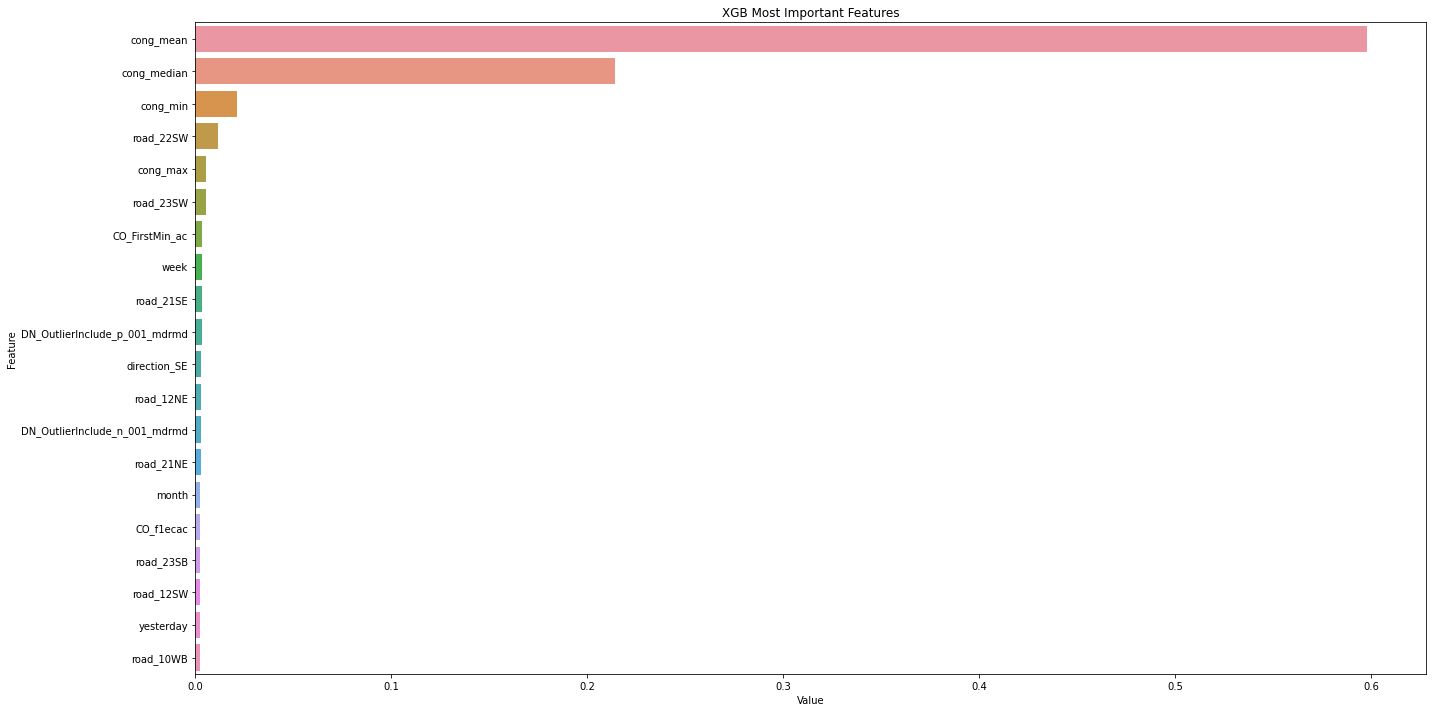

In [5]:
cols = list(X_train_v.columns)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

In [6]:
# Refit for the entire training set
X_train = train.drop(['time','congestion'], axis = 1)
y_train = train.congestion
X_test = test.drop(['time'], axis = 1)

clf.fit(X_train, y_train, eval_set = [(X_train, y_train)],verbose = 100, eval_metric = 'mae')

pred_test = np.round(clf.predict(X_test)).astype("int8")

[0]	validation_0-mae:46.13540
[100]	validation_0-mae:6.72177
[200]	validation_0-mae:5.60516
[300]	validation_0-mae:5.44751
[400]	validation_0-mae:5.33520
[499]	validation_0-mae:5.26098


In [7]:
sub_gbm=sub.copy()
sub_gbm['congestion']=pred_test
sub_gbm.to_csv("submission.csv", index=True)
sub_gbm

,congestion
row_id,
848835,43
848836,35
848837,56
848838,23
848839,72
...,...
851170,68
851171,36
851172,69
